In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [2]:
# read images
image_names = glob("../../data/keyframe_162930/*.jpg")
# image_names = glob("../data/split_fine/*.jpg")
# image_names = glob("../data/stitching/boat*.jpg")
# image_names = glob("../data/test1/DSC_*.jpg")
imgs = []
for i in image_names:
    _i = cv2.imread(i)
    _i = cv2.rotate(_i, cv2.ROTATE_90_CLOCKWISE )
    # _i = cv.resize(_i, (0,0), fx=0.25, fy=0.25)
    imgs.append(_i)
# return imgs, image_names

In [3]:
def warp_img0(src, good0, good1):
    ph, mask = cv2.findHomography(good1, good0, cv2.RANSAC, 5.0)
    # Find the corners after the transform has been applied

    height, width = src.shape
    corners = np.array([
      [0, 0],
      [0, height - 1],
      [width - 1, height - 1],
      [width - 1, 0]
    ])
    corners = cv2.perspectiveTransform(np.float32([corners]), ph)[0]

    # Find the bounding rectangle
    bx, by, bwidth, bheight = cv2.boundingRect(corners)

    # Compute the translation homography that will move (bx, by) to (0, 0)
    th = np.array([
      [ 1, 0, -bx ],
      [ 0, 1, -by ],
      [ 0, 0,   1 ]
    ])

    # Combine the homographies
    pth = ph.dot(th)

    # Apply the transformation to the image
    warped = cv2.warpPerspective(src, pth, (bwidth, bheight), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
    return warped

In [4]:
def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H'''
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    rect = np.int32([t[1], h2+t[1],t[0], w2+t[0]])
    return result, rect

In [5]:
def warpTwoImagesInv(img1, img2, H_inv):
    '''warp img2 to img1 with homograph H'''
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts1_ = cv2.perspectiveTransform(pts1, H_inv)
    pts = np.concatenate((pts1_, pts2), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img1, Ht.dot(H_inv), (xmax-xmin, ymax-ymin))
    result[t[1]:h2+t[1],t[0]:w2+t[0]] = img2
    rect = np.int32([t[1], h2+t[1],t[0], w2+t[0]])
    return result, rect

0 1


<ipython-input-91-c202120878f0>:69: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(_i, tuple(p), 15, (255,0,0), 2)
<ipython-input-91-c202120878f0>:78: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(_j, tuple(p), 15, (255,0,0), 2)
<ipython-input-91-c202120878f0>:82: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(_k, tuple(p), 15, (255,0,0), 2)


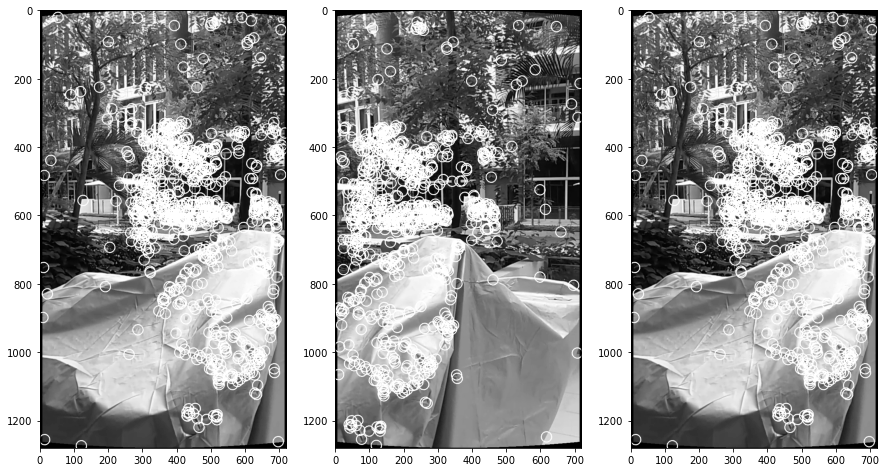

1 2


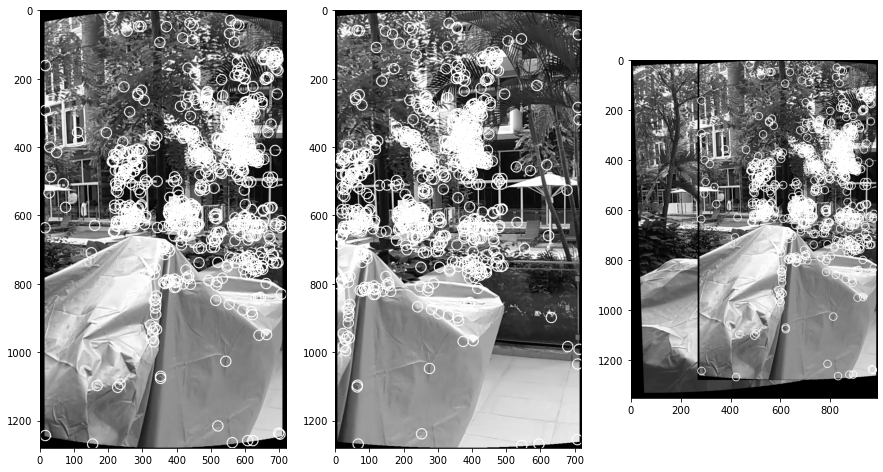

2 3


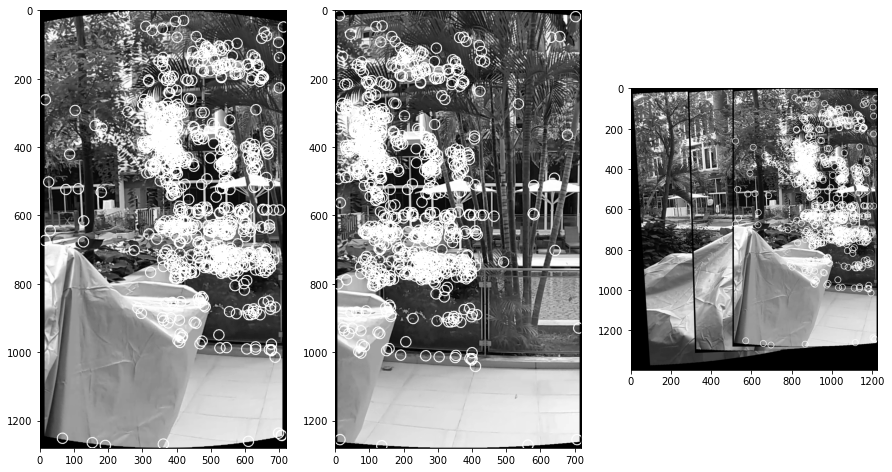

3 4


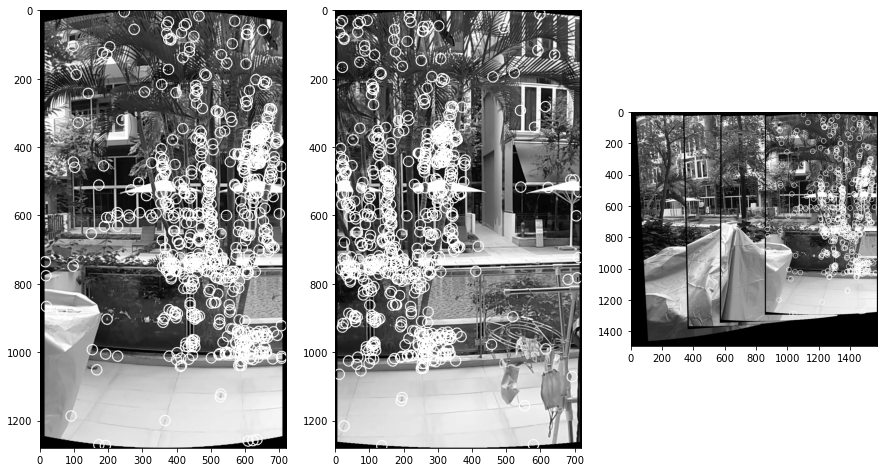

4 5


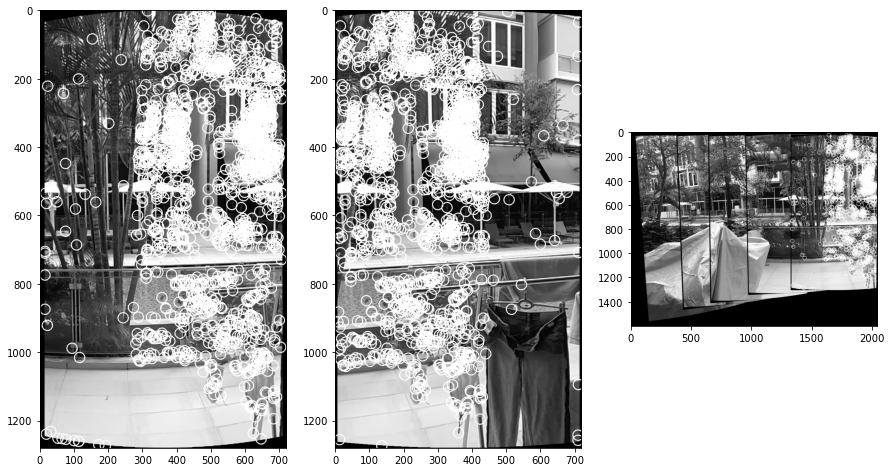

5 6


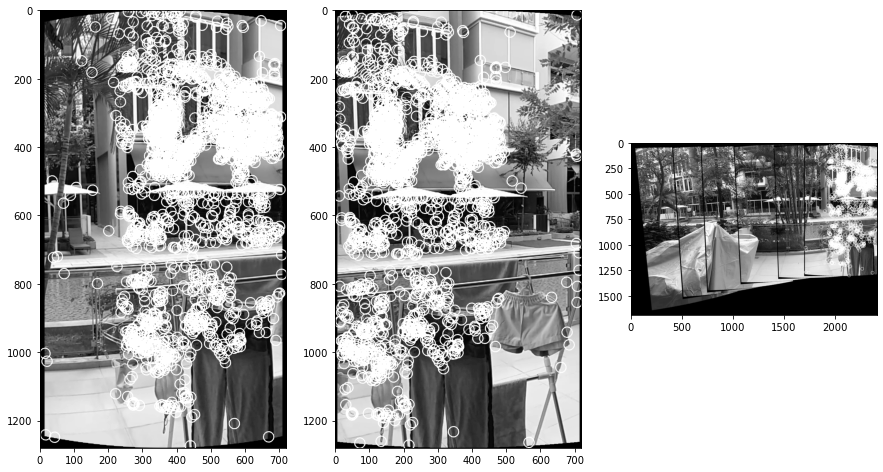

6 7


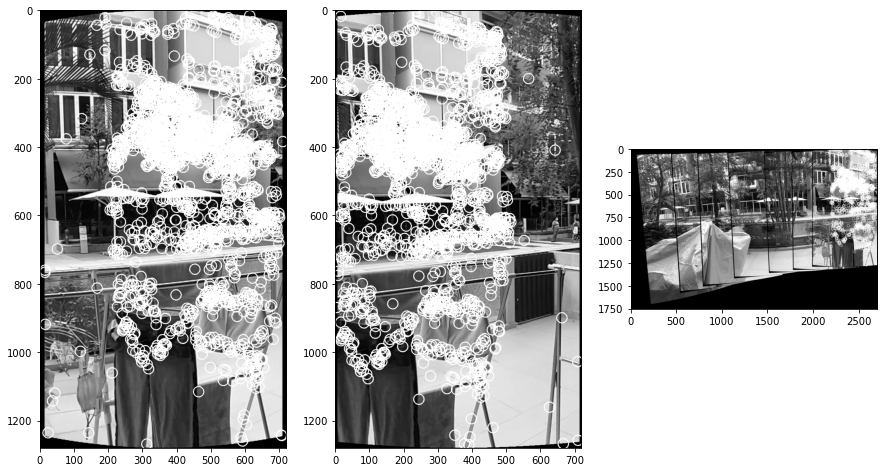

In [91]:
# warp img0/mosaic instead of img1
mosaic = None
rect=[0,0,0,0]

for i, j in zip(range(0, len(imgs)-1), range(1, len(imgs))):
    print(i, j)
    img0 = cv2.cvtColor(imgs[i],cv2.COLOR_BGR2GRAY)
    img1 = cv2.cvtColor(imgs[j],cv2.COLOR_BGR2GRAY)
    
    if mosaic is None:
        img0 = cylindricalWarp(img0, K)[:,:,0]
        mosaic_crop = img0
        mosaic = img0
    else:
        mosaic_crop = mosaic[rect[0]:rect[1], rect[2]:rect[3]]
        # corner, mosaic_crop = warper.warp(mosaic_crop, K, R, cv2.INTER_LINEAR, cv2.BORDER_REFLECT)
        mosaic_crop = cylindricalWarp(mosaic_crop, K)[:,:,0]
        
    # corner, img1 = warper.warp(img1, K, R, cv2.INTER_LINEAR, cv2.BORDER_REFLECT)
    img1 = cylindricalWarp(img1, K)[:,:,0]

    # #gftt
    # # p0 = cv2.goodFeaturesToTrack(img0, mask = None, **feature_params)
    # p0 = cv2.goodFeaturesToTrack(mosaic_crop, mask = None, **feature_params)
# 
    # #oflk
    # p1, st, err = cv2.calcOpticalFlowPyrLK(mosaic_crop, img1, p0, None, **lk_params)
    # # p1, st, err = cv2.calcOpticalFlowPyrLK(img1, mosaic_crop, p0, None, **lk_params)
# 
    # # good points
    # good1 = p1[st==1]
    # good0 = p0[st==1]
    
    sift = cv2.SIFT_create()
    # orb = cv2.ORB_create()
    # find the keypoints and descriptors with SIFT
    kp1, desc1 = sift.detectAndCompute(mosaic_crop, None)
    kp2, desc2 = sift.detectAndCompute(img1, None)
    desc1 = np.float32(desc1)
    desc2 = np.float32(desc2)

    # FLANN parameters: Fast Library for Approximate Nearest Neighbor
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # K=2 => get 2 Nearest Neighbors which is then filtered out after applying a ratio test
    # This filters out around 90% of false matches
    #(Learning OpenCV 3 Computer Vision with Python By Joe Minichino, Joseph Howse)
    matches = flann.knnMatch(desc1, desc2, k=2)                 # Interest points from image2 to image1


    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    good0 = np.float32([kp1[m[0].queryIdx].pt for m in good])# .reshape(-1,1,2)
    good1 = np.float32([kp2[m[0].trainIdx].pt for m in good])# .reshape(-1,1,2)
    
    _i = mosaic_crop.copy()
    
    for p in good0:
        cv2.circle(_i, tuple(p), 15, (255,0,0), 2)
    
    
    # translate back after crop
    MA = np.float32([[1, 0, rect[2]], [0, 1, rect[0]], [0,0,1]])
    good0_ = cv2.perspectiveTransform(good0.reshape(-1,1,2), MA)
    
    _j = mosaic.copy()
    for p in good0_.squeeze():
        cv2.circle(_j, tuple(p), 15, (255,0,0), 2)
        
    _k = img1.copy()
    for p in good1:
        cv2.circle(_k, tuple(p), 15, (255,0,0), 2)
        
    fig, ax = plt.subplots(1, 3, figsize=(15,15))
    ax[0].imshow(_i, cmap='gray')
    ax[1].imshow(_k, cmap='gray')
    ax[2].imshow(_j, cmap='gray')
    plt.show()
    
    M, mask = cv2.findHomography(good1, good0_.squeeze(), cv2.RANSAC, 5.0)
    M_Inv, mask = cv2.findHomography(good0_.squeeze(), good1, cv2.RANSAC, 5.0)

    result, rect = warpTwoImagesInv(mosaic, img1, M_Inv)
    # result, rect = warpTwoImages(mosaic, img1, M)
    # plt.figure(figsize=(9,16))
    # plt.imshow(result)
    # plt.show()
    mosaic = result
    if(i==20):
        break

In [79]:
cv2.imwrite("pano_162930_9.jpg", mosaic)

True

In [7]:
import math
def cylindricalWarpImage(img1, K, savefig=False):
    '''
    https://github.com/TejasNaikk/Image-Alignment-and-Panoramas
    Warp an image from cartesian coordinates (x, y) into cylindrical coordinates (theta, h)
    Returns: (image, mask)
    Mask is [0,255], and has 255s wherever the cylindrical images has a valid value.
    Masks are useful for stitching
    Usage example:
        im = cv2.imread("myimage.jpg",0) #grayscale
        h,w = im.shape
        f = 700
        K = np.array([[f, 0, w/2], [0, f, h/2], [0, 0, 1]]) # mock calibration matrix
        imcyl = cylindricalWarpImage(im, K)
    '''
    f = K[0,0]

    im_h,im_w = img1.shape

    # go inverse from cylindrical coord to the image
    # (this way there are no gaps)
    cyl = np.zeros_like(img1)
    cyl_mask = np.zeros_like(img1)
    cyl_h,cyl_w = cyl.shape
    x_c = float(cyl_w) / 2.0
    y_c = float(cyl_h) / 2.0
    for x_cyl in np.arange(0,cyl_w):
        for y_cyl in np.arange(0,cyl_h):
            theta = (x_cyl - x_c) / f
            h     = (y_cyl - y_c) / f

            X = np.array([math.sin(theta), h, math.cos(theta)])
            X = np.dot(K,X)
            x_im = X[0] / X[2]
            if x_im < 0 or x_im >= im_w:
                continue

            y_im = X[1] / X[2]
            if y_im < 0 or y_im >= im_h:
                continue

            cyl[int(y_cyl),int(x_cyl)] = img1[int(y_im),int(x_im)]
            cyl_mask[int(y_cyl),int(x_cyl)] = 255


    if savefig:
        plt.imshow(cyl, cmap='gray')
        plt.savefig("cyl.png",bbox_inches='tight')

    return (cyl,cyl_mask)

In [67]:
def cylindricalWarp(img, K):
    """This function returns the cylindrical warp for a given image and intrinsics matrix K"""
    h_,w_ = img.shape[:2]
    # pixel coordinates
    y_i, x_i = np.indices((h_,w_))
    X = np.stack([x_i,y_i,np.ones_like(x_i)],axis=-1).reshape(h_*w_,3) # to homog
    Kinv = np.linalg.inv(K) 
    X = Kinv.dot(X.T).T # normalized coords
    # calculate cylindrical coords (sin\theta, h, cos\theta)
    A = np.stack([np.sin(X[:,0]),X[:,1],np.cos(X[:,0])],axis=-1).reshape(w_*h_,3)
    B = K.dot(A.T).T # project back to image-pixels plane
    # back from homog coords
    B = B[:,:-1] / B[:,[-1]]
    # make sure warp coords only within image bounds
    B[(B[:,0] < 0) | (B[:,0] >= w_) | (B[:,1] < 0) | (B[:,1] >= h_)] = -1
    B = B.reshape(h_,w_,-1)
    
    img_rgba = cv2.cvtColor(img,cv2.COLOR_BGR2BGRA) # for transparent borders...
    # warp the image according to cylindrical coords
    return cv2.remap(img_rgba, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_AREA, borderMode=cv2.BORDER_TRANSPARENT)

In [88]:
h,w = img1.shape
f = 1500
K = np.array([[f, 0, w/2], [0, f, h/2], [0, 0, 1]])
# K = np.array([[2.39648083e+03, 0.00000000e+00, 7.78372416e+02],
 # [0.00000000e+00, 2.37689542e+03, 1.31719553e+03],
 # [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]], np.float32)
# imgc = cylindricalWarpImage(img1, K)
imgc2 = cylindricalWarp(img1, K)

In [89]:
imgc2.shape

(1280, 720, 4)

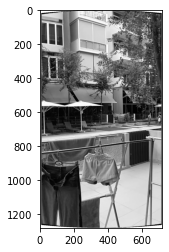

In [90]:
plt.imshow(imgc2)

In [57]:
warper = cv2.PyRotationWarper("cylindrical", 1280)

In [58]:
K = np.array([[2.39648083e+03, 0.00000000e+00, 7.78372416e+02],
 [0.00000000e+00, 2.37689542e+03, 1.31719553e+03],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]], np.float32)
# K = np.array([[352, 0, 118], [0, 352, 210], [0, 0, 1]], np.float32)
R = np.array([[1,0,0], [0,1,0], [0,0,1]], np.float32)
corner, image_wp = warper.warp(imgs[0], K, R, cv2.INTER_LINEAR, cv2.BORDER_REFLECT)


In [59]:
image_wp.shape

(691, 371, 3)

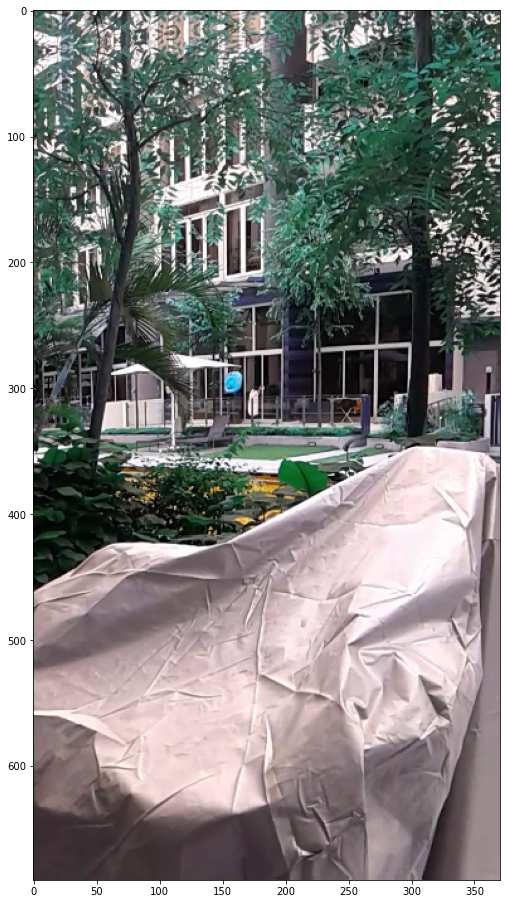

In [60]:
plt.figure(figsize=(9,16))
plt.imshow(image_wp)

In [19]:
imgs[0].shape

(1280, 720, 3)